## Setup

In [61]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers # type: ignore
from tensorflow.keras import models # type: ignore
from IPython import display
tf.keras.layers

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Data Loading and Preprocessing

In [62]:
DATASET_PATH = 'train/audio'
data_dir = pathlib.Path(DATASET_PATH)

TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

In [63]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
words = np.delete(words, np.where(words == '_background_noise_'))
print('Words:', words)

Words: ['right' 'eight' 'cat' 'tree' 'bed' 'happy' 'go' '.DS_Store' 'dog' 'no'
 'wow' 'nine' 'left' 'stop' 'three' 'sheila' 'one' 'bird' 'zero' 'seven'
 'up' 'marvin' 'two' 'house' 'down' 'six' 'yes' 'on' 'five' 'off' 'four']


Loading data with audio_dataset_from_directory. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [64]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

orig_label_names = np.array(train_ds.class_names)
print()
print("Label names:", orig_label_names)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.

Label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [65]:
submission_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=64,
    shuffle=False,
    class_names=None,
    output_sequence_length=16000)

Found 158538 files belonging to 1 classes.


As mentioned in the task, there are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown. At this point for simplicity we will consider silent as unknown.

Changing lables to consider only words of interest:

In [66]:
label_names = np.asarray(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown'])
label_names_map = {label: i for i, label in enumerate(label_names)}

In [67]:
label_names_map

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10}

In [68]:
# Function to map labels
def map_labels(labels):
    # 10 - unknown label
    return np.array([label_names_map.get(orig_label_names[label], 10) for label in labels], dtype=np.int64)

# Transform labels in train and validation datasets
def preprocess_dataset(dataset):
    def map_and_set_shape(x, y):
        # Apply mapping
        y = tf.numpy_function(map_labels, [y], tf.int64)
        # Explicitly set the shape of the labels to be scalar
        y.set_shape([None])  # [] means a scalar label
        return x, y

    return dataset.map(map_and_set_shape, num_parallel_calls=tf.data.AUTOTUNE)

In [69]:
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [70]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

This dataset only contains single channel audio, so the tf.squeeze function is used to drop the extra axis:

In [71]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

submission_ds = submission_ds.map(squeeze, tf.data.AUTOTUNE)

In [72]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

We will use test_ds to evaluate our model after training and submission_ds to predict the labels of the given test data.

Inspecting the shape of a single batch from the training dataset:

In [73]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2024-10-29 23:43:16.169771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [51777]
	 [[{{node Placeholder/_0}}]]
2024-10-29 23:43:16.170317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]


### Plotting Audio Waveforms

In this section, we visualize the waveforms of selected audio samples from our training dataset. Waveforms represent the amplitude of the audio signal over time.

We will plot a grid of waveforms for a set of audio samples, each labeled with its corresponding class name.

In [74]:
label_names[[1,1,3,0]]

array(['no', 'no', 'down', 'yes'], dtype='<U7')

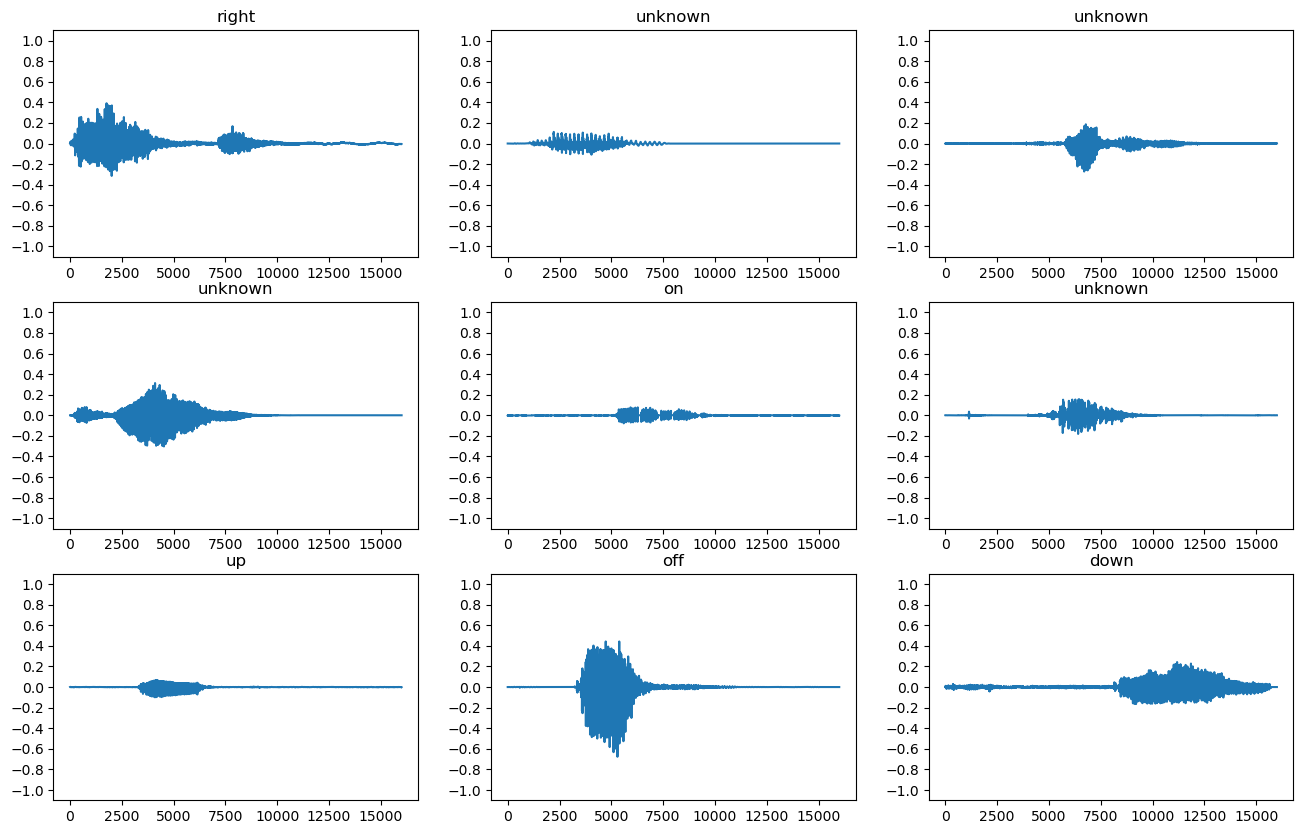

In [75]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

### Converting waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. We'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images.

In [76]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, to explore the data we print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [77]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, we define a function for displaying a spectrogram:

In [78]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

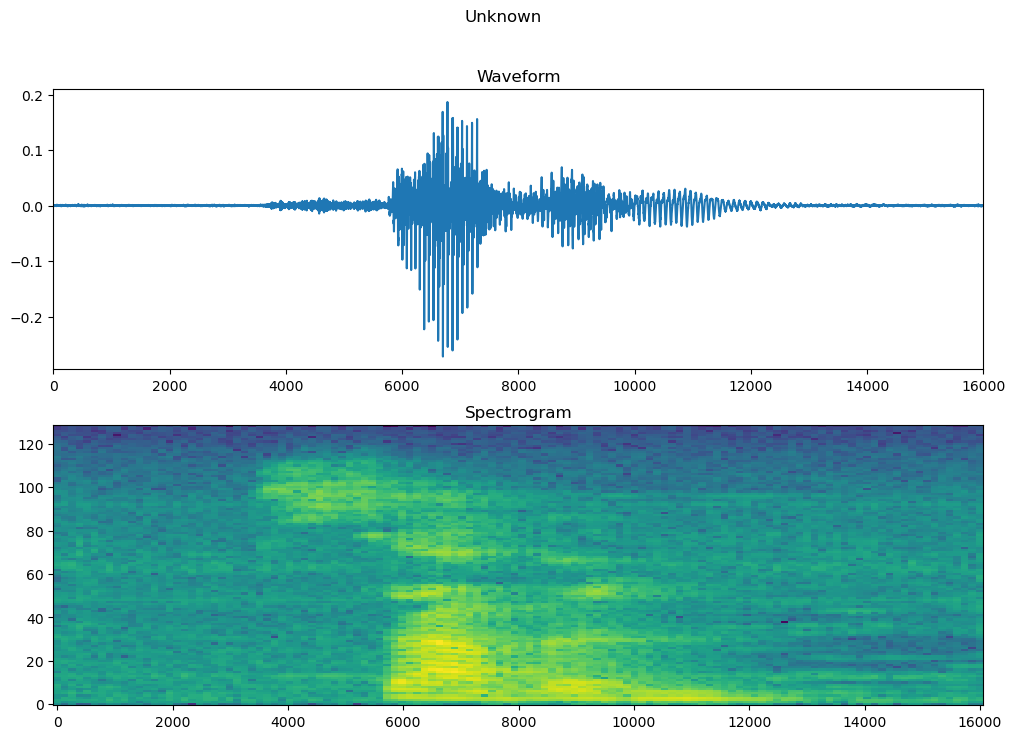

In [79]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Creation of spectrogram datasets from the audio datasets:

In [80]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [81]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
submission_spectrogram_ds = make_spec_ds(submission_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examination of the spectrograms for different examples of the dataset:

In [82]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

2024-10-29 23:43:17.801489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:43:17.801691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [51777]
	 [[{{node Placeholder/_0}}]]


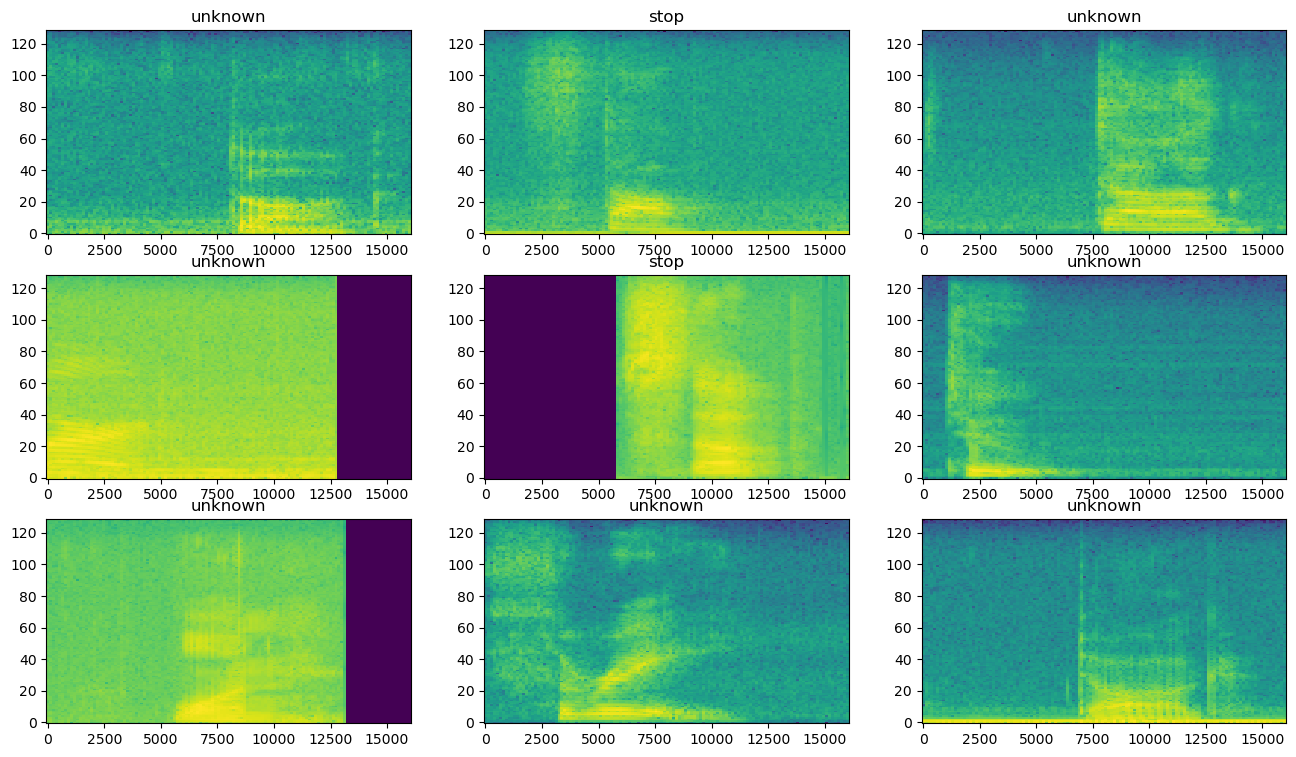

In [83]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Building and training the model

Adding Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [84]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
submission_spectrogram_ds = submission_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Lets, use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

Our model will use the following Keras preprocessing layers:
* tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
* tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [85]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-10-29 23:43:29.979834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:43:29.980140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)       

Configuration of the Keras model with the Adam optimizer and the cross-entropy loss:

In [86]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Training the model over 7 epochs:

In [87]:
EPOCHS = 7

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/7


2024-10-29 23:43:39.421536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:43:39.421798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [51777]
	 [[{{node Placeholder/_4}}]]


809/810 [============================>.] - ETA: 0s - loss: 1.1014 - accuracy: 0.6716

2024-10-29 23:44:07.935500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12944]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:44:07.935705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12944]
	 [[{{node Placeholder/_4}}]]


810/810 [==============================] - 31s 37ms/step - loss: 1.1013 - accuracy: 0.6716 - val_loss: 0.7084 - val_accuracy: 0.7556
Epoch 2/7
810/810 [==============================] - 28s 35ms/step - loss: 0.7261 - accuracy: 0.7607 - val_loss: 0.5401 - val_accuracy: 0.8156
Epoch 3/7
810/810 [==============================] - 27s 34ms/step - loss: 0.5929 - accuracy: 0.8037 - val_loss: 0.4464 - val_accuracy: 0.8489
Epoch 4/7
810/810 [==============================] - 28s 35ms/step - loss: 0.5190 - accuracy: 0.8262 - val_loss: 0.4077 - val_accuracy: 0.8668
Epoch 5/7
810/810 [==============================] - 29s 35ms/step - loss: 0.4626 - accuracy: 0.8457 - val_loss: 0.3677 - val_accuracy: 0.8846
Epoch 6/7
810/810 [==============================] - 28s 35ms/step - loss: 0.4253 - accuracy: 0.8566 - val_loss: 0.3477 - val_accuracy: 0.8888
Epoch 7/7
810/810 [==============================] - 29s 36ms/step - loss: 0.3954 - accuracy: 0.8675 - val_loss: 0.3409 - val_accuracy: 0.8909


Plotting the training and validation loss curves to check how model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

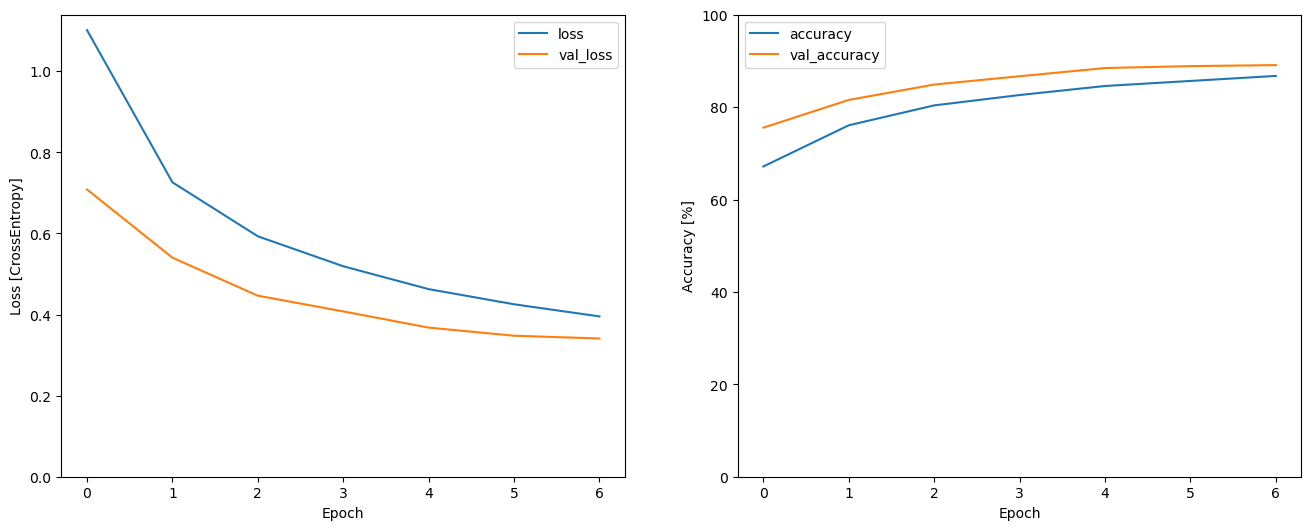

In [88]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluating the model performance

In [89]:
model.evaluate(test_spectrogram_ds, return_dict=True)

  5/102 [>.............................] - ETA: 1s - loss: 0.2832 - accuracy: 0.8938 

2024-10-29 23:47:49.698802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12944]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:47:49.699161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12944]
	 [[{{node Placeholder/_4}}]]


102/102 [==============================] - 3s 28ms/step - loss: 0.3371 - accuracy: 0.8934


{'loss': 0.33709830045700073, 'accuracy': 0.8933641910552979}

### Displaying a confusion matrix and histogram

We'll use a confusion matrix and histogram to check how well the model did classifying each of the words in the test set:

In [90]:
y_pred = model.predict(test_spectrogram_ds)

102/102 [==============================] - 1s 9ms/step


In [91]:
y_pred = tf.argmax(y_pred, axis=1)

In [92]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-10-29 23:47:53.646726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12944]
	 [[{{node Placeholder/_0}}]]
2024-10-29 23:47:53.646928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12944]
	 [[{{node Placeholder/_0}}]]


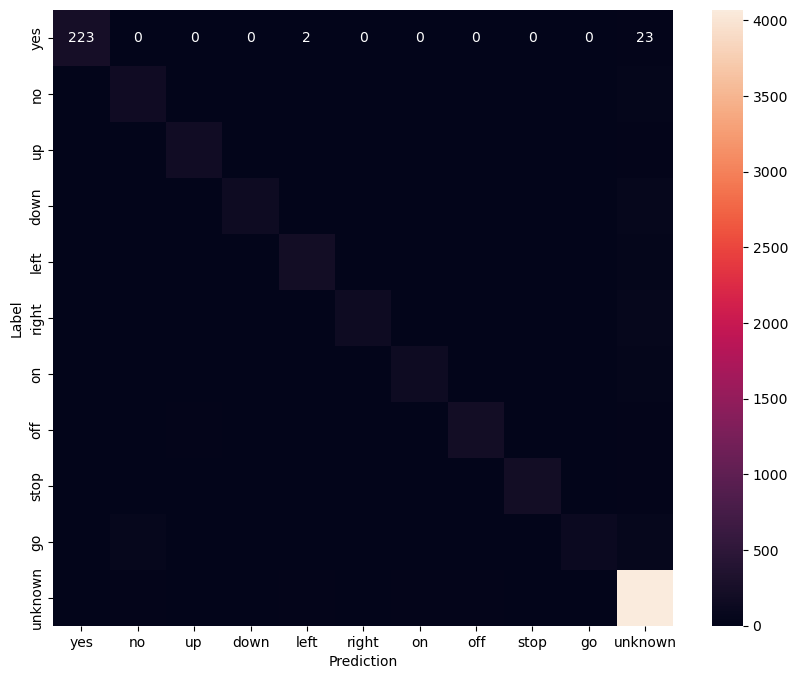

In [93]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [94]:
label_mapping = {index: value for index, value in enumerate(label_names)}

label_texts = [label_mapping[label] for label in y_pred.numpy()]

/Users/bogdan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


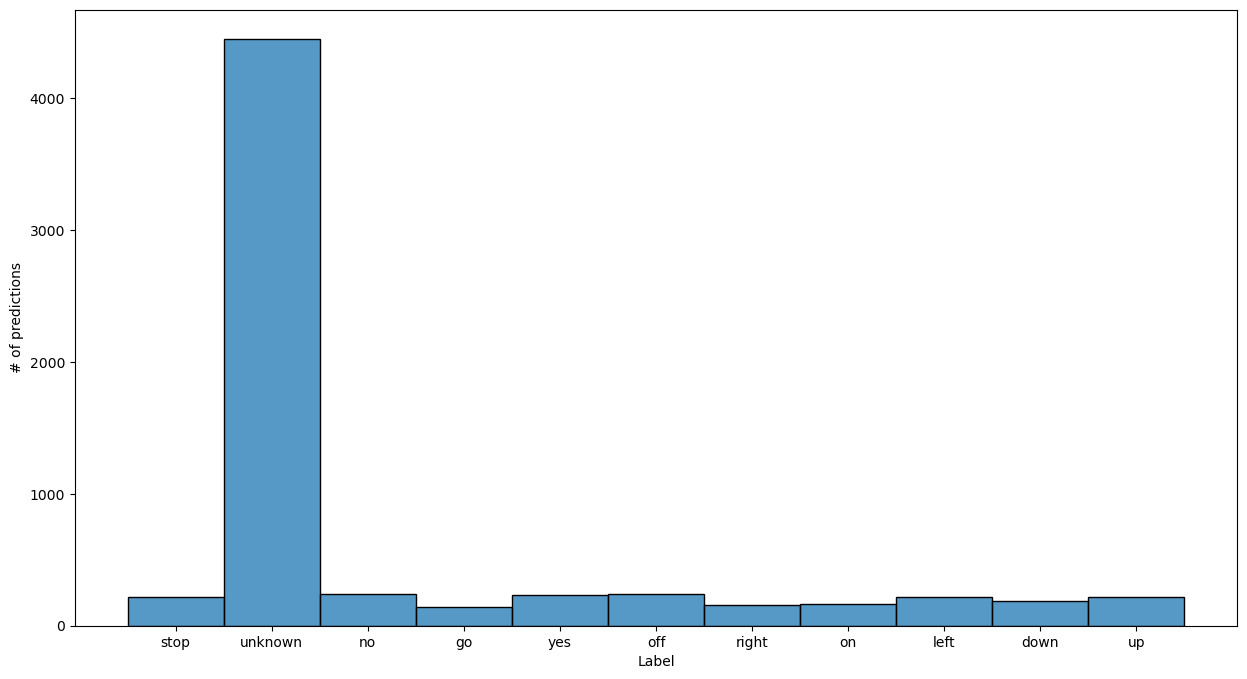

In [95]:
plt.figure(figsize=(15, 8))
sns.histplot(label_texts)
plt.xlabel('Label')
plt.ylabel('# of predictions')
plt.show()

Now, we'll explore confusion matrix and histogram for all labels but unknown:

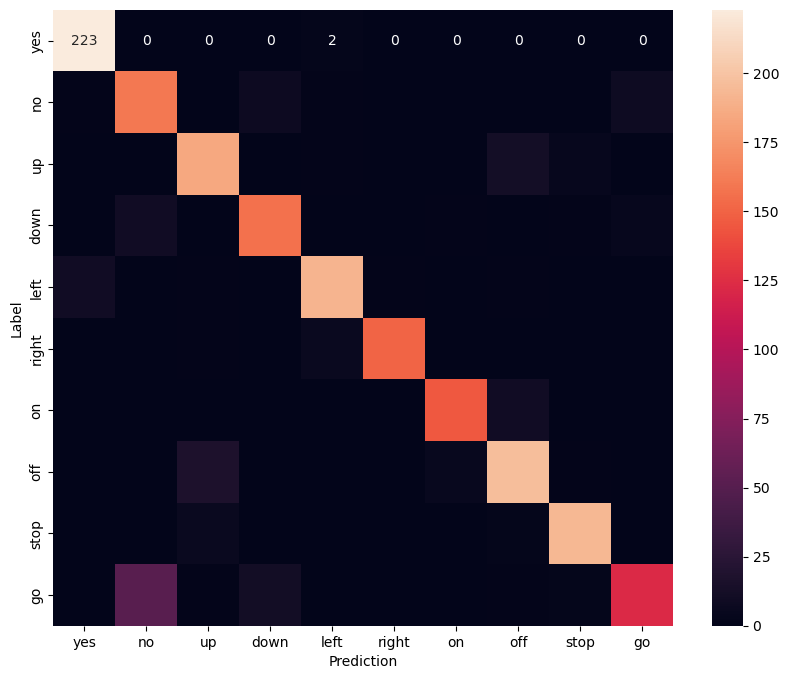

In [96]:
unknown_index = list(label_names).index("unknown")

# Remove "unknown" row and column from confusion matrix
confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=0)  # Remove row
confusion_mtx = np.delete(confusion_mtx, unknown_index, axis=1)  # Remove column

# Remove "unknown" from label names
filtered_labels = np.delete(label_names, unknown_index)

# Plotting the modified confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=filtered_labels,
            yticklabels=filtered_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


/Users/bogdan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


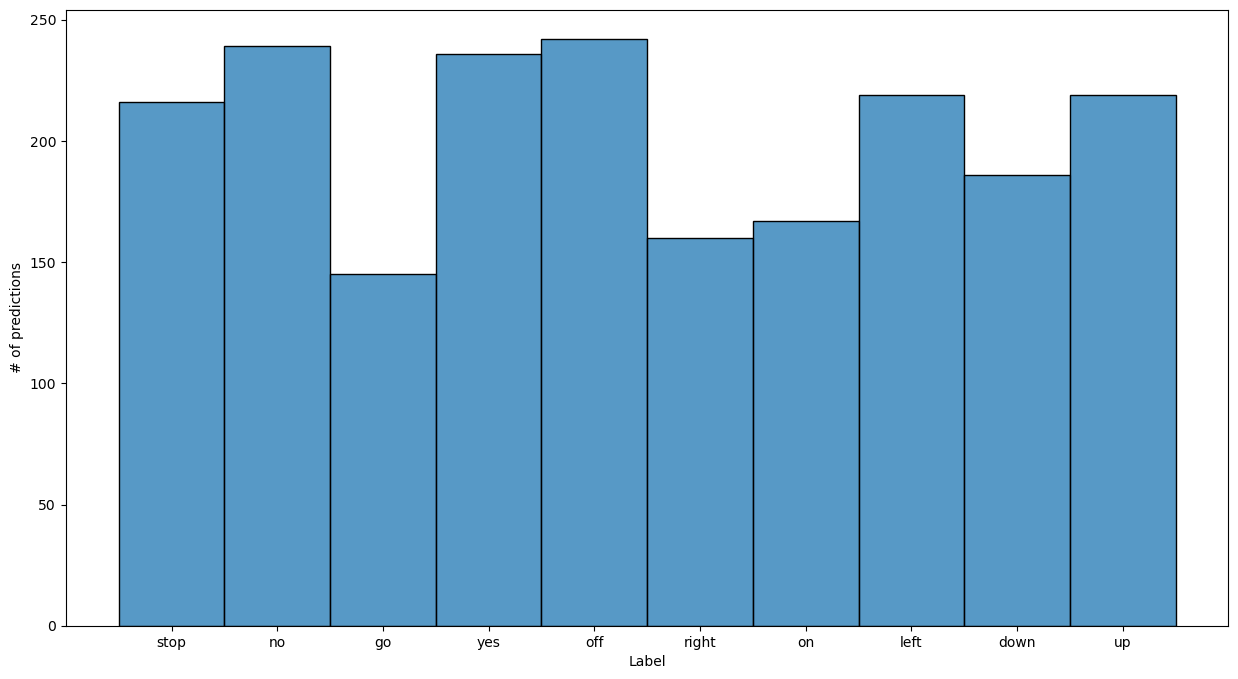

In [97]:
# Create a mapping of indices to labels
label_mapping = {index: value for index, value in enumerate(label_names)}

# Filter out predictions with the "unknown" label
unknown_index = list(label_mapping.values()).index("unknown")
filtered_y_pred = [label for label in y_pred.numpy() if label != unknown_index]

# Map the filtered predictions to their text labels
label_texts = [label_mapping[label] for label in filtered_y_pred]

# Plot the histogram excluding "unknown" predictions
plt.figure(figsize=(15, 8))
sns.histplot(label_texts)
plt.xlabel('Label')
plt.ylabel('# of predictions')
plt.show()


## Predicting labels with the model

Next, we will use our model to predict labels for the test sounds. The results, including each sound's filename and its predicted label, will be saved to a CSV file.

In [98]:
y_pred = model.predict(submission_spectrogram_ds)

   1/2478 [..............................] - ETA: 6:36

2024-10-29 23:48:12.468709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [158538]
	 [[{{node Placeholder/_4}}]]
2024-10-29 23:48:12.469008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [158538]
	 [[{{node Placeholder/_4}}]]


2478/2478 [==============================] - 44s 18ms/step


In [99]:
y_pred = tf.argmax(y_pred, axis=1)

In [100]:
label_mapping = {index: value for index, value in enumerate(label_names)}

label_texts = [label_mapping[label] for label in y_pred.numpy()]

/Users/bogdan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


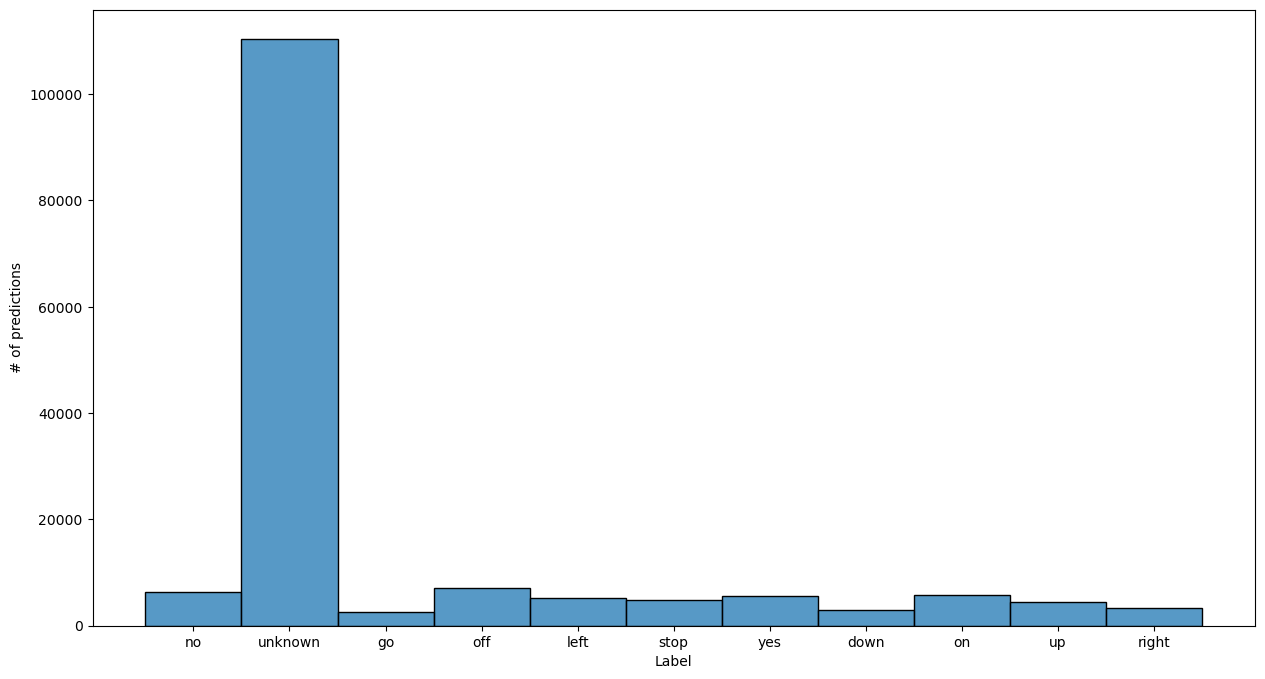

In [101]:
plt.figure(figsize=(15, 8))
sns.histplot(label_texts)
plt.xlabel('Label')
plt.ylabel('# of predictions')
plt.show()

In [102]:
result_df = pd.DataFrame(label_texts, columns=['label'])

file_names = sorted([path.name for path in test_dir.glob("*/*")])
result_df["file"] = file_names

result_df = result_df[['file', 'label']]
result_df.to_csv('submission.csv', index=False)

In [108]:
result_df

,file,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown
...,...,...
158533,clip_fffe49419.wav,unknown
158534,clip_ffff2fb36.wav,down
158535,clip_ffff90f56.wav,stop
158536,clip_ffff98589.wav,unknown


## Verification of models prediction

Let's select a sound and verify its predicted label.

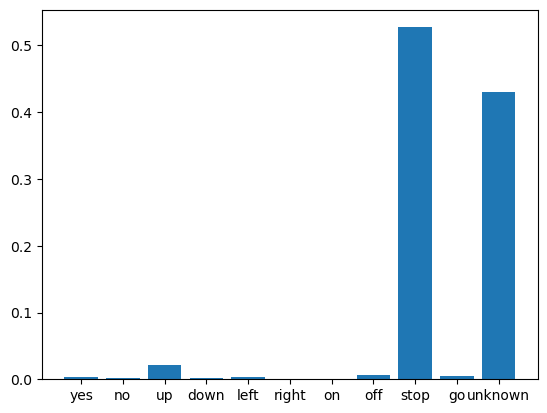

In [111]:
x = test_dir/'audio/clip_ffff90f56.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.show()

display.display(display.Audio(waveform, rate=16000))